In [20]:
import pandas as pd
from pandas import Series, DataFrame

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

import xgboost as xgb  # GBM algorithm
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV   # Updated import for cross-validation and grid search
from sklearn import metrics   # Correct import for metrics

from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

In [21]:
train_data = pd.read_csv('data/new_train.csv')
test_data = pd.read_csv('data/new_test.csv')

display(train_data.head(1))
# display(train_data.info())

display(test_data.head(1))
# display(test_data.info())
train_length = train_data.shape[0]

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,ExterGrade_GdGdGd,ExterGrade_GdGdGdGd,ExterGrade_Po,ExterGrade_PoPo,ExterGrade_TA,ExterGrade_TATA,ExterGrade_TATATA,ExterGrade_TATATATA,Id,SalePrice
0,0.625,0.405761,0.875,0.625,0.998007,0.998007,0.353963,0.440935,0.0,0.096725,...,False,False,False,False,False,False,True,False,1,12.247699


,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,ExterGrade_GdGd,ExterGrade_GdGdGd,ExterGrade_GdGdGdGd,ExterGrade_Po,ExterGrade_PoPo,ExterGrade_TA,ExterGrade_TATA,ExterGrade_TATATA,ExterGrade_TATATATA,Id
0,0.769231,0.523724,0.625,0.75,0.97708,0.97708,0.0,0.312872,0.286817,0.167887,...,False,False,False,False,False,False,True,False,False,1461


In [22]:
import math

def common_num_range(start,stop,step):
    
    startlen = stoplen = steplen = 0
    if '.' in str(start):
        startlen = len(str(start)) - str(start).index('.') - 1
    if '.' in str(stop):
        stoplen = len(str(stop)) - str(stop).index('.') - 1
    if '.' in str(step):
        steplen = len(str(step)) - str(step).index('.') - 1
    
    maxlen = startlen
    if stoplen > maxlen:
        maxlen = stoplen
    if steplen > maxlen:
        maxlen = steplen
    
    power = math.pow(10, maxlen)
    
    if startlen == 0 and stoplen == 0 and steplen == 0:
        return range(start, stop, step)
    else:
        return [num / power for num in range(int(start*power), int(stop*power), int(step*power))]


In [23]:
train_id = train_data['Id']
train_Y = train_data['SalePrice']
train_data.drop(['Id', 'SalePrice'], axis=1, inplace=True)
train_X = train_data

test_Id = test_data['Id']
test_data.drop('Id', axis=1, inplace=True)
test_X = test_data

In [24]:
# formatting for xgb
dtrain = xgb.DMatrix(train_X, label=train_Y)
dtest = xgb.DMatrix(test_X)

# XGBoost  & Parameter Tuning

Ref: [Complete Guide to Parameter Tuning in XGBoost](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)

## Parameters Tuning Plan

The overall parameters can be divided into 3 categories:

1. General Parameters: Guide the overall functioning
2. Booster Parameters: Guide the individual booster (tree/regression) at each step
3. Learning Task Parameters: Guide the optimization performed

In `XGBRegressor`:
```
class xgboost.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, objective='reg:linear', nthread=-1, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, seed=0, missing=None)
```

In [25]:
# The error metric: RMSE on the log of the sale prices.
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [48]:
def model_cross_validate(xgb_regressor, cv_paramters, dtrain, cv_folds=5, early_stopping_rounds=50, perform_progress=False):
    """
    XGBoost model cross-validation to choose best parameters from given cv_parameters.

    Parameters:
    cv_parameters : dict
        Dictionary where keys are parameter names and values are lists of parameter settings to test.
    dtrain : xgboost.DMatrix
        Training data formatted for XGBoost.
    early_stopping_rounds : int
        Activates early stopping. Stops when performance does not improve for 'early_stopping_rounds'.
    perform_progress : bool
        If True, prints out progress and RMSE statistics for each parameter setting.
    """
    # Retrieve initial parameters
    xgb_param = xgb_regressor.get_xgb_params()

    # Ensure n_estimators is included
    if 'n_estimators' not in xgb_param:
        if hasattr(xgb_regressor, 'n_estimators'):
            xgb_param['n_estimators'] = xgb_regressor.n_estimators
        else:
            xgb_param['n_estimators'] = 100  # default value or chosen heuristic

    # Save best parameters
    best_params = {}
    best_cvresult = None
    min_mean_rmse = float("inf")

    for param, values in cv_paramters.items():
        print('=========== Tuning parameter:', param, '===========')
        best_param_value = values[0]  # initial assumption: first value is the best

        for value in values:
            # Set the parameter's value
            xgb_param[param] = value

            # Perform cross-validation
            cvresult = xgb.cv(
                xgb_param,
                dtrain,
                num_boost_round=xgb_param['n_estimators'],
                nfold=cv_folds,
                metrics='rmse',
                early_stopping_rounds=early_stopping_rounds,
                seed=10
            )

            # Calculate the mean of the last several RMSEs
            round_count = cvresult.shape[0]
            mean_rmse = cvresult.loc[round_count - 11:round_count - 1, 'test-rmse-mean'].mean()

            if perform_progress:
                std_rmse = cvresult.loc[round_count - 11:round_count - 1, 'test-rmse-std'].mean()
                print(f"{param}={value} CV RMSE: Mean = {mean_rmse:.7g} | Std = {std_rmse:.7g}")

            # Update the best parameters if the current RMSE is better
            if mean_rmse < min_mean_rmse:
                best_param_value = value
                best_cvresult = cvresult
                min_mean_rmse = mean_rmse

        # Update the best parameter and xgb parameters for next parameter testing
        best_params[param] = best_param_value
        xgb_param[param] = best_param_value
        print(f"Best {param}: {best_params[param]}")

    return best_params, min_mean_rmse, best_cvresult

In [49]:
def model_fit(xgb_regressor, train_x, train_y, performCV=True, printFeatureImportance=True, cv_folds=5):
    # Ensure that n_estimators is set
    if not hasattr(xgb_regressor, 'n_estimators') or xgb_regressor.n_estimators is None:
        xgb_regressor.set_params(n_estimators=100)

    if performCV:
        dtrain = xgb.DMatrix(train_x, label=train_y)
        xgb_param = xgb_regressor.get_xgb_params()
        
        # It is important to pass an integer to num_boost_round; ensure it is set
        n_estimators = xgb_regressor.n_estimators if xgb_regressor.n_estimators is not None else 100
        cvresult = xgb.cv(xgb_param, dtrain, num_boost_round=n_estimators, 
                          nfold=cv_folds, metrics='rmse', 
                          early_stopping_rounds=50, seed=10)
        round_count = cvresult.shape[0]
        mean_rmse = cvresult.loc[round_count-11:round_count-1,'test-rmse-mean'].mean()
        std_rmse = cvresult.loc[round_count-11:round_count-1,'test-rmse-std'].mean()

        print("CV RMSE : Mean = %.7g | Std = %.7g" % (mean_rmse, std_rmse))

        # Update n_estimators to the best iteration if early stopping is enabled
        xgb_regressor.set_params(n_estimators=round_count)

    # Fit the training data
    xgb_regressor.fit(train_x, train_y, eval_metric='rmse')

    # Predict training set
    train_predictions = xgb_regressor.predict(train_x)
    mse = mean_squared_error(train_y, train_predictions)
    print("Train RMSE: %.7f" % np.sqrt(mse))
    
    # Initialize feature_importances to avoid returning None if not set
    feature_importances = None
    
    # Print Feature Importance
    if printFeatureImportance and hasattr(xgb_regressor, 'feature_importances_'):
        feature_importances = pd.Series(xgb_regressor.feature_importances_, index=train_x.columns)
        feature_importances = feature_importances.sort_values(ascending=False).head(40)
        feature_importances.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        plt.show()
    
    return xgb_regressor, feature_importances


Baseline XGBRegressor

CV RMSE : Mean = 0.1360057 | Std = 0.01085209
Train RMSE: 0.0306967


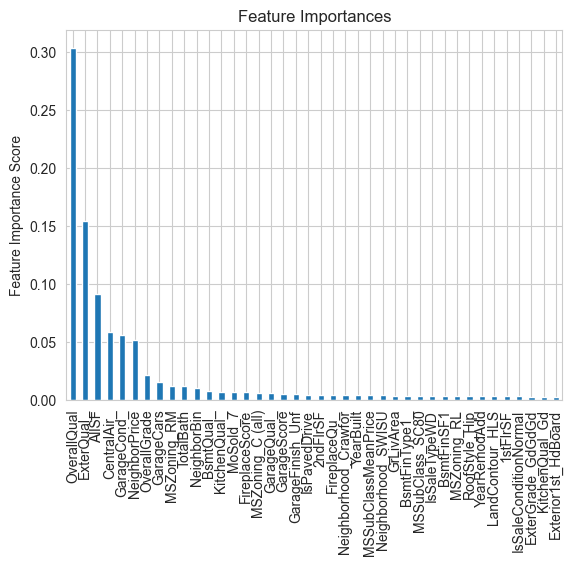

In [50]:
xgb_regressor = XGBRegressor(seed=10)
xgb_regressor, feature_importances = model_fit(xgb_regressor,train_X, train_Y)

### 1. Choose a relatively high learning_rate,optimum n_estimators

In [51]:
param_test = {'n_estimators':range(300,400,10)}

xgb_regressor = XGBRegressor(
                learning_rate =0.05,

                max_depth=5,
                min_child_weight=1,
                gamma=0,
                subsample=0.8,
                colsample_bytree=0.8,
                reg_lambda = 0.1,
                reg_alpha = 0.1,
                scale_pos_weight=1,
                objective= 'reg:linear',
                seed=10)

best_param, min_mean_rmse, best_cvresult = \
                model_cross_validate(xgb_regressor, param_test, dtrain, perform_progress=True)

print('cross-validate best params:', best_param)
print('cross-validate min_mean_rmse:', min_mean_rmse)

=========== Tuning parameter: n_estimators ===========
n_estimators=300 CV RMSE: Mean = 0.1246264 | Std = 0.01077551
n_estimators=310 CV RMSE: Mean = 0.1246264 | Std = 0.01077551
n_estimators=320 CV RMSE: Mean = 0.1246264 | Std = 0.01077551
n_estimators=330 CV RMSE: Mean = 0.1246264 | Std = 0.01077551
n_estimators=340 CV RMSE: Mean = 0.1246264 | Std = 0.01077551
n_estimators=350 CV RMSE: Mean = 0.1246264 | Std = 0.01077551
n_estimators=360 CV RMSE: Mean = 0.1246264 | Std = 0.01077551
n_estimators=370 CV RMSE: Mean = 0.1246264 | Std = 0.01077551
n_estimators=380 CV RMSE: Mean = 0.1246264 | Std = 0.01077551
n_estimators=390 CV RMSE: Mean = 0.1246264 | Std = 0.01077551
Best n_estimators: 300
cross-validate best params: {'n_estimators': 300}
cross-validate min_mean_rmse: 0.1246264452290137


CV RMSE : Mean = 0.1246264 | Std = 0.01077551
Train RMSE: 0.0389861


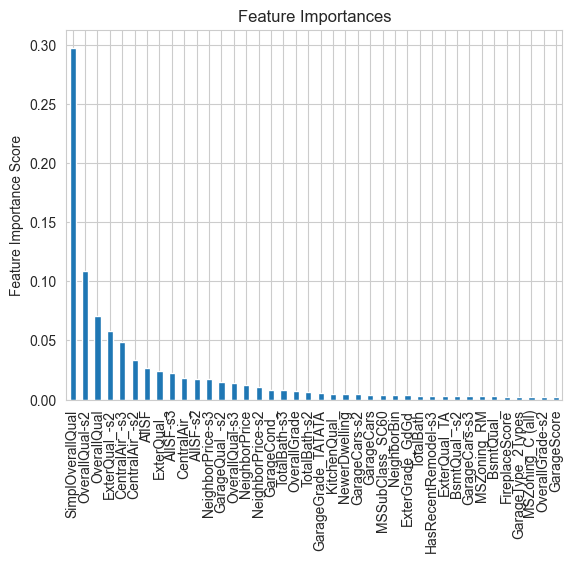

In [52]:
xgb_regressor = XGBRegressor(
                learning_rate =0.05,
                n_estimators = 300,

                max_depth=5,
                min_child_weight=1,
                gamma=0,
                subsample=0.8,
                colsample_bytree=0.8,
                reg_lambda = 0.1,
                reg_alpha = 0.1,
                scale_pos_weight=1,
                objective= 'reg:linear',
                seed=10)

xgb_regressor, feature_importances = model_fit(xgb_regressor,train_X, train_Y)

### 2.Fix learning rate and number of estimators for tuning tree-based parameters

Tune `max_depth` and `min_child_weight`

In [53]:
param_test = {'max_depth':range(1,6,1),
               'min_child_weight':common_num_range(1,2,0.1)}

xgb_regressor = XGBRegressor(
                learning_rate =0.05,
                n_estimators = 300,
    
                gamma=0,
                subsample=0.8,
                colsample_bytree=0.8,
                reg_lambda = 0.1,
                reg_alpha = 0.1,
                scale_pos_weight=1,
                objective= 'reg:linear',
                seed=10)

best_param, min_mean_rmse, best_cvresult = \
                model_cross_validate(xgb_regressor, param_test, dtrain, perform_progress=True)

print('cross-validate best params:', best_param)
print('cross-validate min_mean_rmse:', min_mean_rmse)

=========== Tuning parameter: max_depth ===========
max_depth=1 CV RMSE: Mean = 0.1290447 | Std = 0.009851683
max_depth=2 CV RMSE: Mean = 0.1228977 | Std = 0.008416339
max_depth=3 CV RMSE: Mean = 0.1226166 | Std = 0.009003687
max_depth=4 CV RMSE: Mean = 0.121559 | Std = 0.01014232
max_depth=5 CV RMSE: Mean = 0.1246264 | Std = 0.01077551
Best max_depth: 4
=========== Tuning parameter: min_child_weight ===========
min_child_weight=1.0 CV RMSE: Mean = 0.121559 | Std = 0.01014232
min_child_weight=1.1 CV RMSE: Mean = 0.122432 | Std = 0.009467774
min_child_weight=1.2 CV RMSE: Mean = 0.122432 | Std = 0.009467774
min_child_weight=1.3 CV RMSE: Mean = 0.122432 | Std = 0.009467774
min_child_weight=1.4 CV RMSE: Mean = 0.122432 | Std = 0.009467774
min_child_weight=1.5 CV RMSE: Mean = 0.122432 | Std = 0.009467774
min_child_weight=1.6 CV RMSE: Mean = 0.122432 | Std = 0.009467774
min_child_weight=1.7 CV RMSE: Mean = 0.122432 | Std = 0.009467774
min_child_weight=1.8 CV RMSE: Mean = 0.122432 | Std = 0.0

CV RMSE : Mean = 0.1226272 | Std = 0.009388169
Train RMSE: 0.0694999


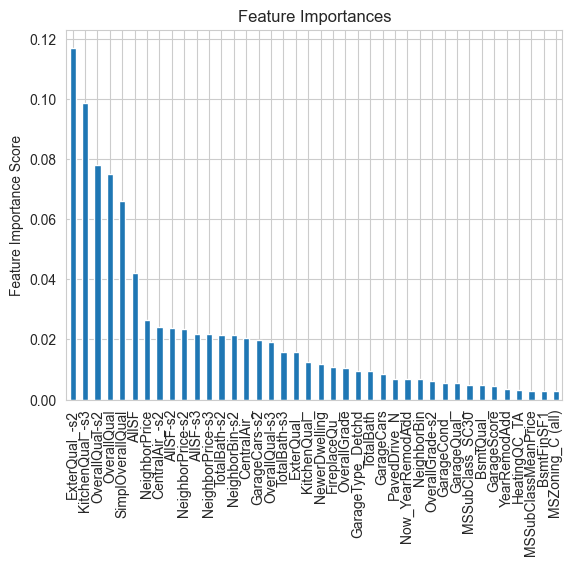

In [54]:
xgb_regressor = XGBRegressor(
                learning_rate =0.05,
                n_estimators = 300,
                max_depth=3,
                min_child_weight=1.1,
    
                gamma=0,
                subsample=0.8,
                colsample_bytree=0.8,
                reg_lambda = 0.1,
                reg_alpha = 0.1,
                scale_pos_weight=1,
                objective= 'reg:linear',
                seed=10)

xgb_regressor, feature_importances = model_fit(xgb_regressor,train_X, train_Y)

Tune `gamma`,Minimum loss reduction required to make a further partition on a leaf node of the tree. 

In [55]:
param_test = {'gamma':[0, 0.1, 0.01, 0.001,0.0001, 0.00001]}

xgb_regressor = XGBRegressor(
                learning_rate =0.05,
                n_estimators = 300,
                max_depth=3,
                min_child_weight=1.1,
    
                subsample=0.8,
                colsample_bytree=0.8,
                reg_lambda = 0.1,
                reg_alpha = 0.1,
                scale_pos_weight=1,
                objective= 'reg:linear',
                seed=10)

best_param, min_mean_rmse, best_cvresult = \
                model_cross_validate(xgb_regressor, param_test, dtrain, perform_progress=True)

print('cross-validate best params:', best_param)
print('cross-validate min_mean_rmse:', min_mean_rmse)

=========== Tuning parameter: gamma ===========
gamma=0 CV RMSE: Mean = 0.1226272 | Std = 0.009388169
gamma=0.1 CV RMSE: Mean = 0.1262446 | Std = 0.00918824
gamma=0.01 CV RMSE: Mean = 0.122801 | Std = 0.009417475
gamma=0.001 CV RMSE: Mean = 0.1224809 | Std = 0.009334298
gamma=0.0001 CV RMSE: Mean = 0.1225927 | Std = 0.009488292
gamma=1e-05 CV RMSE: Mean = 0.1226281 | Std = 0.009388184
Best gamma: 0.001
cross-validate best params: {'gamma': 0.001}
cross-validate min_mean_rmse: 0.12248087489478282


CV RMSE : Mean = 0.122801 | Std = 0.009417475
Train RMSE: 0.0699881


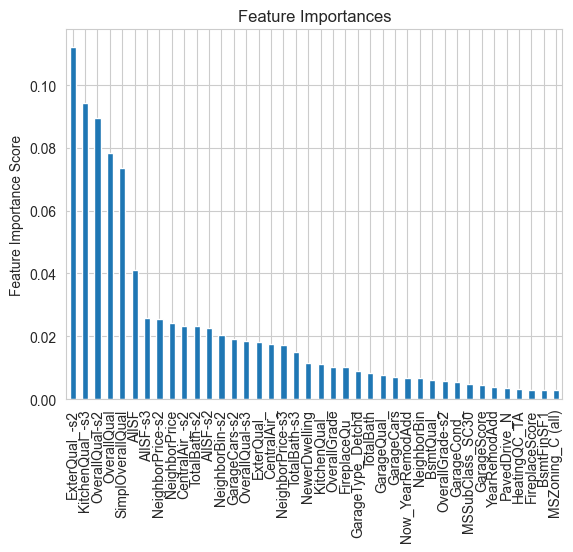

In [56]:
xgb_regressor = XGBRegressor(
                learning_rate =0.05,
                n_estimators = 300,
                max_depth=3,
                min_child_weight=1.1,
                gamma=0.01,
    
                subsample=0.8,
                colsample_bytree=0.8,
                reg_lambda = 0.1,
                reg_alpha = 0.1,
                scale_pos_weight=1,
                objective= 'reg:linear',
                seed=10)

xgb_regressor, feature_importances = model_fit(xgb_regressor,train_X, train_Y)

Tune `subsample` and `colsample_bytree`

- subsample : Subsample ratio of the training instance.
- colsample_bytree : Subsample ratio of columns when constructing each tree

In [57]:
param_test = {'subsample':common_num_range(0.6, 0.9, 0.01),
               'colsample_bytree':common_num_range(0.6, 0.9, 0.01)}

xgb_regressor = XGBRegressor(
                learning_rate =0.05,
                n_estimators = 300,
                max_depth=3,
                min_child_weight=1.1,
                gamma=0.01,
    
                reg_lambda = 0.1,
                reg_alpha = 0.1,
                scale_pos_weight=1,
                objective= 'reg:linear',
                seed=10)

best_param, min_mean_rmse, best_cvresult = \
                model_cross_validate(xgb_regressor, param_test, dtrain, perform_progress=True)

print('cross-validate best params:', best_param)
print('cross-validate min_mean_rmse:', min_mean_rmse)

=========== Tuning parameter: subsample ===========
subsample=0.6 CV RMSE: Mean = 0.1206816 | Std = 0.009039457
subsample=0.61 CV RMSE: Mean = 0.121309 | Std = 0.009330252
subsample=0.62 CV RMSE: Mean = 0.1222364 | Std = 0.008773707
subsample=0.63 CV RMSE: Mean = 0.1213312 | Std = 0.009404531
subsample=0.64 CV RMSE: Mean = 0.122773 | Std = 0.008794739
subsample=0.65 CV RMSE: Mean = 0.1226592 | Std = 0.009787527
subsample=0.66 CV RMSE: Mean = 0.1231657 | Std = 0.009734417
subsample=0.67 CV RMSE: Mean = 0.1215953 | Std = 0.009697674
subsample=0.68 CV RMSE: Mean = 0.1221516 | Std = 0.009905919
subsample=0.69 CV RMSE: Mean = 0.12327 | Std = 0.009242587
subsample=0.7 CV RMSE: Mean = 0.1221062 | Std = 0.009554457
subsample=0.71 CV RMSE: Mean = 0.1222117 | Std = 0.00983301
subsample=0.72 CV RMSE: Mean = 0.121563 | Std = 0.0101332
subsample=0.73 CV RMSE: Mean = 0.1220917 | Std = 0.01089812
subsample=0.74 CV RMSE: Mean = 0.1218417 | Std = 0.009597784
subsample=0.75 CV RMSE: Mean = 0.1213667 | S

CV RMSE : Mean = 0.1219494 | Std = 0.009521475
Train RMSE: 0.0747658


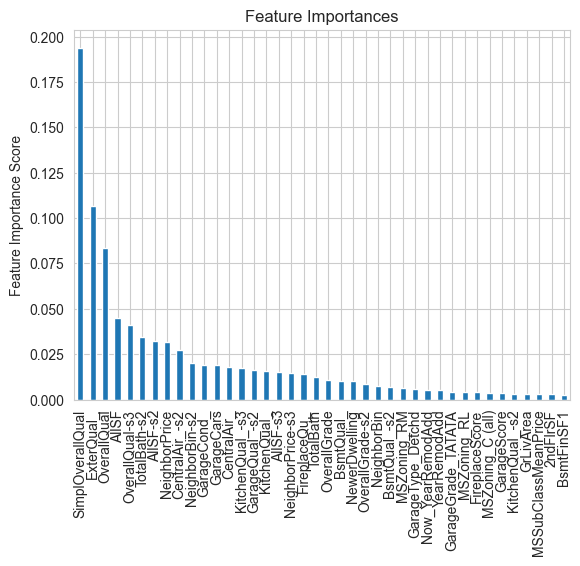

In [58]:
xgb_regressor = XGBRegressor(
                learning_rate =0.05,
                n_estimators = 300,
                max_depth=3,
                min_child_weight=1.1,
                gamma=0.01,
                subsample=0.72,
                colsample_bytree=0.89,
    
                reg_lambda = 0.1,
                reg_alpha = 0.1,
                scale_pos_weight=1,
                objective= 'reg:linear',
                seed=10)

xgb_regressor, feature_importances = model_fit(xgb_regressor,train_X, train_Y)

In [59]:
param_test2 = {'reg_lambda':common_num_range(0.55, 0.65, 0.01),
               'reg_alpha':common_num_range(0.45, 0.6, 0.01)}

xgb_regressor = XGBRegressor(
                learning_rate =0.05,
                n_estimators = 300,
                max_depth=3,
                min_child_weight=1.1,
                gamma=0.01,
                subsample=0.72,
                colsample_bytree=0.89,
    
                scale_pos_weight=1,
                objective= 'reg:linear',
                seed=10)

best_param, min_mean_rmse, best_cvresult = \
                model_cross_validate(xgb_regressor, param_test2, dtrain, perform_progress=True)

print('cross-validate best params:', best_param)
print('cross-validate min_mean_rmse:', min_mean_rmse)

=========== Tuning parameter: reg_lambda ===========
reg_lambda=0.55 CV RMSE: Mean = 0.1225771 | Std = 0.009543968
reg_lambda=0.56 CV RMSE: Mean = 0.1226819 | Std = 0.008801797
reg_lambda=0.57 CV RMSE: Mean = 0.1228867 | Std = 0.009976307
reg_lambda=0.58 CV RMSE: Mean = 0.1229249 | Std = 0.009798794
reg_lambda=0.59 CV RMSE: Mean = 0.1230708 | Std = 0.009837783
reg_lambda=0.6 CV RMSE: Mean = 0.1227501 | Std = 0.0102413
reg_lambda=0.61 CV RMSE: Mean = 0.1224778 | Std = 0.01000848
reg_lambda=0.62 CV RMSE: Mean = 0.1229441 | Std = 0.008683276
reg_lambda=0.63 CV RMSE: Mean = 0.1229495 | Std = 0.009650331
reg_lambda=0.64 CV RMSE: Mean = 0.1231511 | Std = 0.00993456
Best reg_lambda: 0.61
=========== Tuning parameter: reg_alpha ===========
reg_alpha=0.45 CV RMSE: Mean = 0.1220804 | Std = 0.009640935
reg_alpha=0.46 CV RMSE: Mean = 0.1223081 | Std = 0.009466572
reg_alpha=0.47 CV RMSE: Mean = 0.1220796 | Std = 0.008985883
reg_alpha=0.48 CV RMSE: Mean = 0.122119 | Std = 0.009062202
reg_alpha=0.49 

CV RMSE : Mean = 0.1220597 | Std = 0.009210684
Train RMSE: 0.0798729


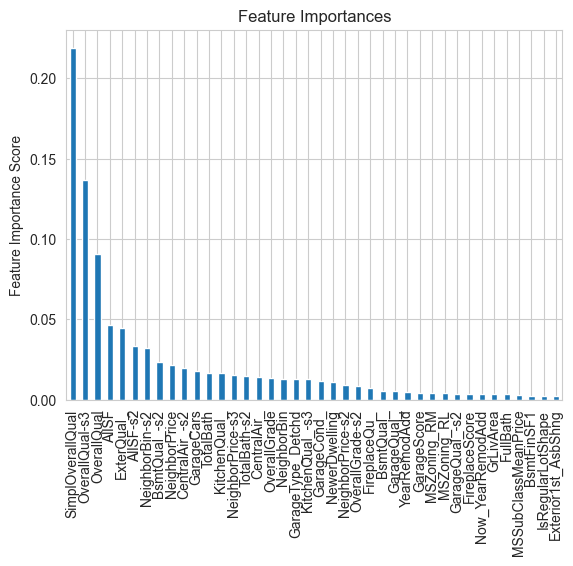

In [60]:
xgb_regressor = XGBRegressor(
                learning_rate =0.05,
                n_estimators = 300,
                max_depth=3,
                min_child_weight=1.1,
                gamma=0.01,
                subsample=0.72,
                colsample_bytree=0.89,
                reg_lambda = 0.61,
                reg_alpha = 0.53,
    
                scale_pos_weight=1,
                objective= 'reg:linear',
                seed=10)

xgb_regressor, feature_importances = model_fit(xgb_regressor,train_X, train_Y)                                           

CV RMSE : Mean = 0.121322 | Std = 0.008808047
Train RMSE: 0.0743782


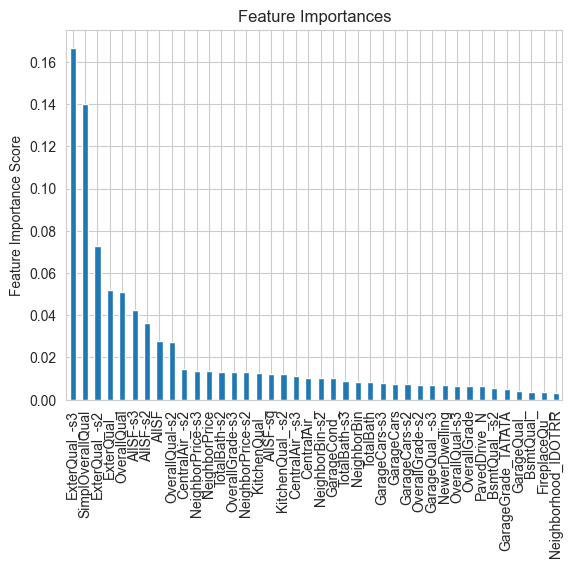

In [61]:
xgb_regressor = XGBRegressor(
                learning_rate =0.01,
                n_estimators = 4000,
                max_depth=3,
                min_child_weight=1.1,
                gamma=0.01,
                subsample=0.72,
                colsample_bytree=0.89,
                reg_lambda = 0.61,
                reg_alpha = 0.53,
    
                scale_pos_weight=1,
                objective= 'reg:linear',
                seed=10)

xgb_regressor, feature_importances = model_fit(xgb_regressor,train_X, train_Y)                                           

Final paramters:

```
xgb_regressor = XGBRegressor(
                learning_rate =0.01,
                n_estimators = 4000,
                max_depth=3,
                min_child_weight=1.1,
                gamma=0.01,
                subsample=0.72,
                colsample_bytree=0.89,
                reg_lambda = 0.61,
                reg_alpha = 0.53,
    
                scale_pos_weight=1,
                objective= 'reg:linear',
                seed=10)
```

In [62]:
xgb_predictions = xgb_regressor.predict(test_X)
xgb_predictions = np.expm1(xgb_predictions)

submission = pd.DataFrame({
        "Id": test_Id,
        "SalePrice": xgb_predictions
    })

submission.to_csv("result/xgb_param_tune_predictions_2_13.csv", index=False)

# Model Voting

Ridge, ElasticNet, Lasso, XGBRegressor model voting.

In [64]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    train_X, train_Y, test_size=0.4, random_state=0
)

In [65]:
from sklearn.linear_model import Ridge, ElasticNet, Lasso

def simple_model_cross_validate(alphas, Model, model_name):
    min_rmse = float('inf')
    best_alpha = None
    for alpha in alphas:
        model = Model(alpha, max_iter=50000).fit(X_train, y_train)
        model_rmse = rmse(model.predict(X_test), y_test)
        if model_rmse < min_rmse:
            best_alpha = alpha
            min_rmse = model_rmse

    print(model_name, 'best_alpha = ', best_alpha, 'min_rmse = ', min_rmse)

alphas = common_num_range(0.0001, 0.002, 0.0001)
simple_model_cross_validate(alphas, Lasso, 'Lasso')
simple_model_cross_validate(alphas, ElasticNet, 'ElasticNet')

Lasso best_alpha =  0.0006 min_rmse =  0.11112663555338818
ElasticNet best_alpha =  0.0018 min_rmse =  0.11214982532056476


In [66]:
alphas = common_num_range(25, 50, 1)
simple_model_cross_validate(alphas, Ridge, 'Ridge')

Ridge best_alpha =  31 min_rmse =  0.11726993208950551


In [67]:
lasso_model = Lasso(alpha=0.0009, max_iter=50000).fit(X_train, y_train)
elastic_net_model = ElasticNet(alpha=0.0019, max_iter=50000).fit(X_train, y_train)
ridge_model = Ridge(alpha=41, max_iter=50000).fit(X_train, y_train)

In [68]:
lasso_predictions = lasso_model.predict(test_X)
lasso_predictions = np.expm1(lasso_predictions)

ridge_predictions = ridge_model.predict(test_X)
ridge_predictions = np.expm1(ridge_predictions)

elastic_net_predictions = elastic_net_model.predict(test_X)
elastic_net_predictions = np.expm1(elastic_net_predictions)

In [69]:
predictions = (lasso_predictions + ridge_predictions + elastic_net_predictions + xgb_predictions) / 4

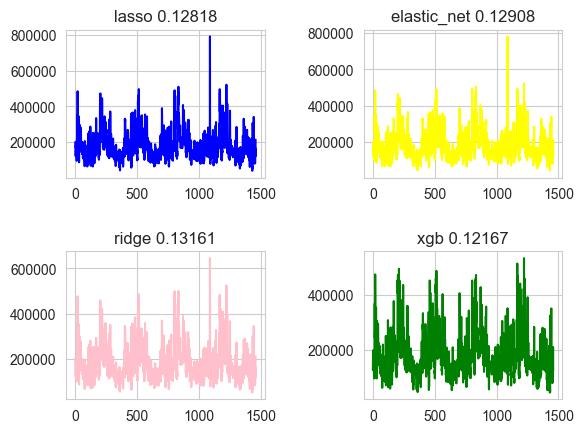

Text(0.5, 1.0, '4 model vote 0.12419')

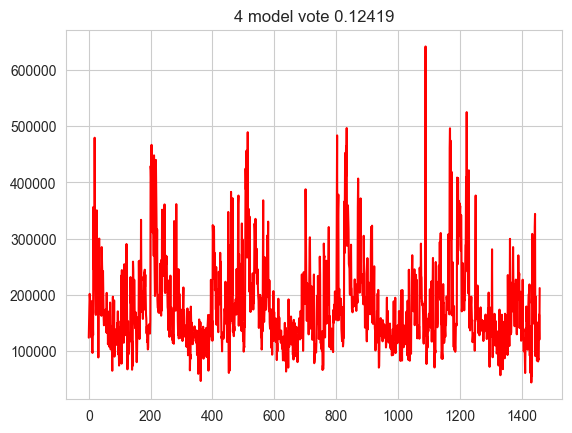

In [70]:
plt.subplot(221)
plt.plot(lasso_predictions, c="blue")  # 0.12818
plt.title('lasso 0.12818')
plt.subplot(222)
plt.plot(elastic_net_predictions, c="yellow")  # 0.12908
plt.title('elastic_net 0.12908')
plt.subplot(223)
plt.plot(ridge_predictions, c="pink")  # 0.13161
plt.title('ridge 0.13161')
plt.subplot(224)
plt.plot(xgb_predictions, c="green")  # 0.12167
plt.title('xgb 0.12167')
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()
plt.subplot(111)
plt.plot(predictions, c="red")  # 0.12419
plt.title('4 model vote 0.12419')

In [71]:
# outlier data
np.argwhere(lasso_predictions == lasso_predictions[lasso_predictions > 700000])

array([[1089]], dtype=int64)

In [72]:
# convert outlier data to xgb_predictions[1089]
lasso_predictions[1089] =  xgb_predictions[1089]
ridge_predictions[1089] =  xgb_predictions[1089]
elastic_net_predictions[1089] =  xgb_predictions[1089]

In [73]:
lasso_score = 1-0.12818
ridge_score = 1-0.13161
elastic_net_score = 1-0.12908
xgb_score = 1-0.12167
total_score = lasso_score + ridge_score + elastic_net_score + xgb_score
predictions = (lasso_score / total_score) * lasso_predictions + \
              (ridge_score / total_score) * ridge_predictions + \
              (elastic_net_score / total_score) * elastic_net_predictions + \
              (xgb_score / total_score) * xgb_predictions

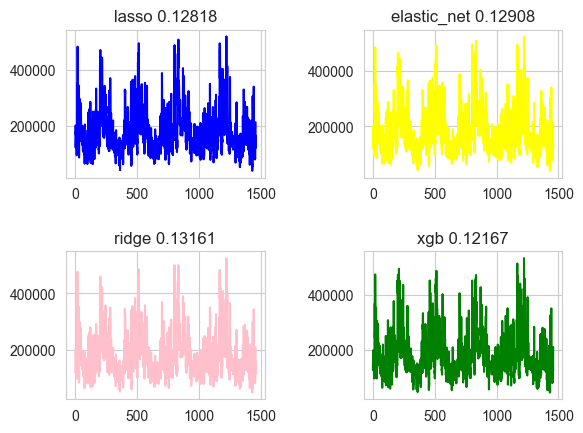

Text(0.5, 1.0, '4 model vote 0.12417')

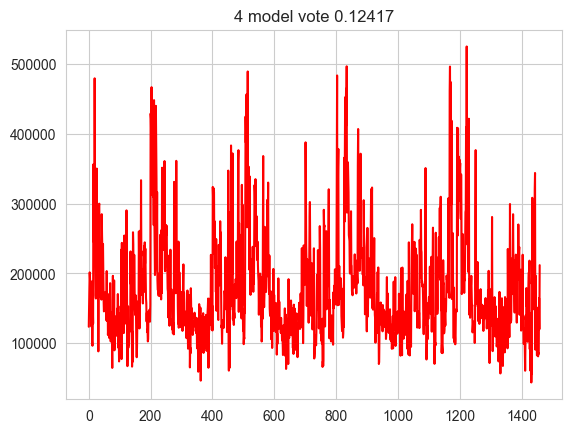

In [74]:
plt.subplot(221)
plt.plot(lasso_predictions, c="blue")  # 0.12818
plt.title('lasso 0.12818')
plt.subplot(222)
plt.plot(elastic_net_predictions, c="yellow")  # 0.12908
plt.title('elastic_net 0.12908')
plt.subplot(223)
plt.plot(ridge_predictions, c="pink")  # 0.13161
plt.title('ridge 0.13161')
plt.subplot(224)
plt.plot(xgb_predictions, c="green")  # 0.12167
plt.title('xgb 0.12167')
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()
plt.subplot(111)
plt.plot(predictions, c="red")  # 0.12417
plt.title('4 model vote 0.12417')

In [76]:
submission = pd.DataFrame({
        "Id": test_Id,
        "SalePrice": lasso_predictions
    })
submission.to_csv("result/lasso_predictions_2_13.csv", index=False)

submission = pd.DataFrame({
        "Id": test_Id,
        "SalePrice": ridge_predictions
    })
submission.to_csv("result/ridge_predictions_2_13.csv", index=False)

submission = pd.DataFrame({
        "Id": test_Id,
        "SalePrice": elastic_net_predictions
    })
submission.to_csv("result/elastic_net_predictions_2_13.csv", index=False)

submission = pd.DataFrame({
        "Id": test_Id,
        "SalePrice": xgb_predictions
    })
submission.to_csv("result/xgb_predictions_2_13.csv", index=False)

submission = pd.DataFrame({
        "Id": test_Id,
        "SalePrice": predictions
    })
submission.to_csv("result/4_model_vote_predictions_2_13.csv", index=False)

# Best Vote Score

In [77]:
from sklearn.linear_model import LassoCV

model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(train_X, train_Y)
print(rmse(model_lasso.predict(train_X), train_Y))
lasso_predictions = model_lasso.predict(test_X)
lasso_predictions = np.expm1(lasso_predictions)

0.10115402661203193


In [78]:
predictions = (lasso_predictions + xgb_predictions) / 2
submission = pd.DataFrame({
        "Id": test_Id,
        "SalePrice": predictions
    })
submission.to_csv("result/lasso_xgb_vote_predictions_2_13.csv", index=False)

In [79]:
lasso_score = 1-0.12818
xgb_score = 1-0.12167
total_score = lasso_score + xgb_score
predictions = (lasso_score / total_score) * lasso_predictions + \
              (xgb_score / total_score) * xgb_predictions
            
submission = pd.DataFrame({
        "Id": test_Id,
        "SalePrice": predictions
    })
submission.to_csv("result/lasso_xgb_weighted_vote_predictions_2_13.csv", index=False)